In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
#from sklearn.metrics import plot_confusion_matrix
from scipy import stats

# Get Predictions from the model

In [40]:
def preprocess_dataframe(df, dep_var, images_path):
    df = df[~np.isnan(df[dep_var])]
    return df

def append_predictions(df, preds, column_name = 'predictions'):
    df[column_name] = preds
    return df   

In [146]:
root_path = Path(r'C:\Users\William\Google Drive (william.dl.cameron@gmail.com)\Insight Project')
project_path = root_path/'Output_Food'
models_path = project_path/'Models'
images_path = project_path/'Images'
figures_path = project_path/'Figures'; figures_path.mkdir(exist_ok = True)
df = pd.read_csv(project_path/'processed_dataframe.csv')

dep_var = 'engagement_factor_moving_avg'
df = preprocess_dataframe(df, dep_var, images_path)

In [242]:
test_data = (ImageList.from_df(df, images_path, suffix = '.jpg', cols = 'filename')
             .filter_by_func(lambda x: (images_path/x).exists()))
learn = load_learner(models_path,'First Attempt.pkl', test = test_data)
preds = learn.get_preds(ds_type = DatasetType.Test)
df2 = append_predictions(filtered_df, preds[0])
df2.to_csv(project_path/'final_with_predictions.csv') 

C:\Users\William\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\William\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\William\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source at

# Validation

In [143]:
def get_stats(series):
    return series.mean(), series.std()

def normalize(series, mean, std):
    m, s = get_stats(series)
    new_series = np.add(np.multiply(np.subtract(series,m),(std/s)), mean)
    return new_series

def prepare_df(df, pred_col, target_col):
    df[norm_col] = normalize(df[pred_col], *get_stats(df[target_col]))
    
    return df

def make_accuracy_scatter(df, pred_col, target_col):
    sns.set_context("talk")
    sns.set_style("white")
    g = sns.lmplot(x = target_col, y = pred_col, data = df, aspect = 1, 
                   scatter_kws={"color":"darkred","alpha":0.3,"s":50})
    g.set_axis_labels('Target', 'Prediction')
    return g

def make_thresholded_confusion_matrix(df, pred_col, target_col, threshold, normalize_rows = True):
    
    pred = df[pred_col]
    target = df[target_col]
    TP = pred[target<threshold]<threshold
    FP = pred[target>threshold]<threshold
    FN = pred[target>=threshold]<threshold
    TN = pred[target>=threshold]>=threshold


    classifications = [TP, FP, FN, TN]
    confusion_data = np.array([x.mean() for x in classifications]).reshape(-1, 2)
    if normalize_rows: confusion_data = [x/x.sum() for x in confusion_data]

    hm = sns.heatmap(confusion_data, annot=True, xticklabels = ['True', 'False'], yticklabels= ['True', 'False'])
    ax= hm.axes
    ax.set_ylim(2,0)
    ax.set_xlabel('Target')
    ax.set_ylabel('Prediction')
    return ax



def make_time_map(df):
    groups = df.groupby(['hour', 'day_name']).mean()[dep_var].unstack()
    groups = groups/groups.mean()
    groups.index = (groups.index-5)%24
    groups = groups.sort_index()
    groups.to_csv(figures_path/'time_data.csv')
    xticklabels = ['M','Tu','W','Th','F','Sa','Su']
    g = sns.heatmap(groups, cmap = 'coolwarm_r', xticklabels=xticklabels)
    ax= g.axes
    
    ax.set_xlabel('Day')
    ax.set_ylabel('Hour (EST)')
    #ax.set_yticks(ax.get_yticks()[::2])
    #print(ax.get_yticks())
    #plt.yticks(ax.get_yticks()[::2], ax.get_yticks()[::2], rotation='horizontal')
    ax.set_ylim(24,0)
    plt.yticks(rotation = 'horizontal')

    return ax


def make_violin_plot(df, param):
    plt.figure()
    max_value = 255
    df[f'{param}_bins'] = pd.cut(df[param], bins = 8) #qcut cuts into equal observations
    g = sns.violinplot(x=df[f'{param}_bins'], y=df[dep_var])
    g.set(xlabel = param.capitalize(), ylabel = 'Engagement', xticklabels = np.linspace(32,256,8, dtype='uint16'))
    save_seaborn_plot(g, figures_path/f'ViolinPlot-{param}.png')


def save_seaborn_plot(f, filepath):
    ax = f.get_figure()
    ax.tight_layout()
    ax.savefig(filepath)

In [147]:
DUD_THRESH = 0.7
project_path = project_path
target_col = dep_var  #dep_var
pred_col = 'prediction'
norm_col = 'normalized_preds'


df = pd.read_csv(project_path/'final_with_predictions.csv')
df = prepare_df(df, pred_col, target_col)
get_stats(df[target_col]),get_stats(df[pred_col]), get_stats(df[norm_col])

((1.0074510837493706, 0.45115332489611126),
 (0.9948368577003677, 0.14062542318527368),
 (1.0074510837493722, 0.45115332489611315))

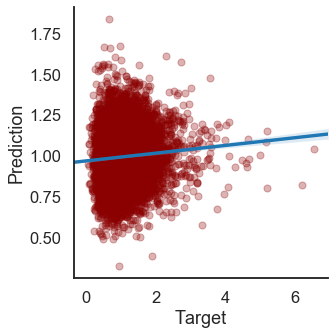

In [44]:
scatter_plt = make_accuracy_scatter(df, pred_col, target_col)
scatter_plt.savefig(figures_path/'target_vs_prediction.png')

In [45]:
stats.linregress(df[target_col],df[pred_col])

LinregressResult(slope=0.02357888418024164, intercept=0.9710822852793833, rvalue=0.07564558210247094, pvalue=5.093467915982664e-19, stderr=0.0026424328382458474)

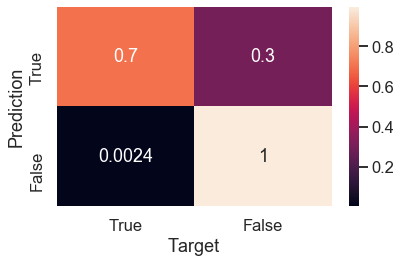

In [152]:
cf_matrix = make_thresholded_confusion_matrix(df, pred_col, target_col, 0.6, normalize_rows = True)
save_seaborn_plot(cf_matrix, figures_path/'confusion_matrix_duds.png')

# Additional Metrics

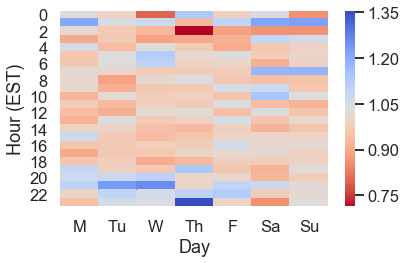

In [149]:
#Time dependency of likes
g = make_time_map(df)
save_seaborn_plot(g, figures_path/'time_dependency.png')

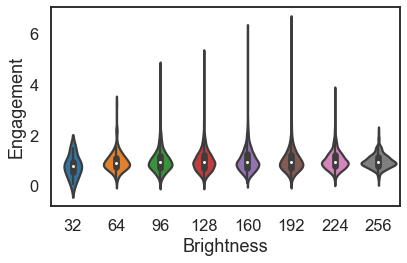

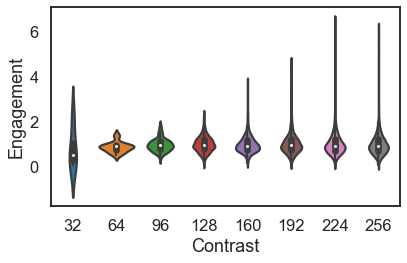

In [148]:
#Violin Plots
for param in ['brightness', 'contrast']:
    make_violin_plot(df, param)


In [154]:
#g = sns.violinplot(x=df[f'username'], y=df[dep_var])
#g.set(xlabel = param.capitalize(), ylabel = 'Engagement', xticklabels = np.linspace(32,256,8, dtype='uint16'))

0.4511370221759984

In [159]:
niches = ['Output_Guys', 'Output_Food']

for niche in niches:
    niche_df = pd.read_csv(root_path/niche/'processed_dataframe.csv')
    print(np.std(niche_df[dep_var]))



0.3945647636384851
0.45106345763213535


In [349]:
groups.index

MultiIndex([( 0, 1),
            ( 0, 2),
            ( 0, 3),
            ( 0, 4),
            ( 0, 5),
            ( 0, 6),
            ( 0, 7),
            ( 1, 1),
            ( 1, 2),
            ( 1, 3),
            ...
            (22, 5),
            (22, 6),
            (22, 7),
            (23, 1),
            (23, 2),
            (23, 3),
            (23, 4),
            (23, 5),
            (23, 6),
            (23, 7)],
           names=['hour', 'day_name'], length=168)

ValueError: Length mismatch: Expected 6825 rows, received array of length 1

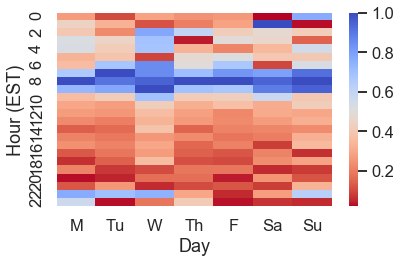

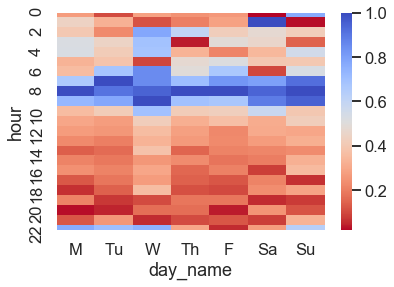

In [ ]:
f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(2, 2)


ax_confusion_matrix = f.add_subplot(gs[0, 0])
sns.heatmap(cm2, annot=True, ax = ax_confusion_matrix)
ax_confusion_matrix.set_ylim(2, 0)

ax_pred_outcome = f.add_subplot(gs[0,1])
outt = sns.lmplot(x = target_col, y = pred_col, data = df)

outt.axes[0] = f.add_subplot(gs[0,1])